#### Adamantios Zaras AM: 06
#### Panagiotis Souranis AM: 17

# Description

In this part of the project, we focused on the most frequent class of the dataset and created a bag of words representation.  
Then, we split half of the test data to test and half to an unlabeled pool.  
We searched for an algorithm and hyperparameters which perform good in the problem and used it in order to compare the uncertainty sampling method with a naive random sampling approach. We implemented the comparison, using the following algorithm:
``` python
for a predefined number of iterations:
    for uncertainty sampling and random sampling methods:
        fit classifier to the train dataset.
        predict to the test dataset.
        keep the resulting accuracy.
        pick a sample from the pool based on the method.
        move the sample from the pool to the train dataset
        
plot learning curves, using the resulting accuracies of the two methods.
```


# Global

## Imports

In [0]:
import warnings
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as sp
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from progressbar import progressbar

from utils import load_dataset, hyperparameters_search
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Prepare Dataset

Load the dataset as a binary problem, using the most frequent class.  
Split the test set to 50% test and 50% unlabeled set, randomly.

In [0]:
# Load dataset.
X_train, y_train, X_test, y_test = load_dataset(path='MLTM/Data/Delicious', 
                                                            maxlen=200, binary=True)

# Split test set to test and unlabeled.
print('Splitting test data to test and unlabeled sets.')
X_unlabeled, X_test, y_hidden, y_test = train_test_split(X_test, y_test, 
                                                         test_size=.5, random_state=0)
print('{} test sequences.'.format(X_test.shape[0]))
print('{} unlabeled sequences.'.format(X_unlabeled.shape[0]))

Loading data...
8251 train sequences
3983 test sequences
X_train shape: (8251, 200)
X_test shape: (3983, 200)

Getting the most frequent class...
The most frequent class was the word 'reference', with 3181 appearances.
Splitting test data to test and unlabeled sets.
1992 test sequences.
1991 unlabeled sequences.


# Hyperparameters search

Define an SVM, a Decision Tree and a Multinomial Naive Bayes, in order to perform hyperparameter search.

In [0]:
# Define classifiers.
classifiers = {
        'SVM': SVC(random_state=0),
        'Tree': DecisionTreeClassifier(random_state=0),
        'Bayes': MultinomialNB()
}

## Random Search

First, we perform a Random Search.

In [0]:
# Create param dists.
svm_param_dist = {'C': 10 ** np.random.uniform(-3, 3, size=7000),
                  'gamma': np.random.uniform(.0001, .1, size=7000)
}
tree_param_dist = {'max_depth': scipy.stats.randint(1, 30),
                   'max_features': scipy.stats.randint(1, X_train.shape[1]),
                   'min_samples_split': scipy.stats.randint(2, X_train.shape[0] / 2),
                   'criterion': ['gini', 'entropy']
}
# Add param dists to a list.
params_list = [svm_param_dist, tree_param_dist]

# Perform random search.
for key, classifier ,params in zip(classifiers.keys(), classifiers.values(), params_list):
    hyperparameters_search(classifier, params, X_train, y_train, 'Accuracy',
                           {'Accuracy': make_scorer(accuracy_score)}, key, 
                           candidates=100, cv=5, random_search=True, verbose=5)


Εstimator : SVM
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 53.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 81.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 90.9min finished


Best parameters found for Estimator : SVM
{'gamma': 0.08062747202788748, 'C': 0.3818514063910508}

Best score found for Accuracy Score metric : 0.614

Εstimator : Tree
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


Best parameters found for Estimator : Tree
{'criterion': 'entropy', 'max_depth': 24, 'max_features': 49, 'min_samples_split': 3147}

Best score found for Accuracy Score metric : 0.615


## Grid Search

We perform a Grid Search around the best areas that were found with the Random search above.

In [0]:
# Create parameter grids.
svm_grid = {'C': np.arange(0.36, 0.4, .01),
            'gamma': np.arange(0.06, 0.1, .01)
}
tree_grid = {
        'max_depth': range(23, 26),
        'max_features': range(47, 51),
        'min_samples_split': range(3146, 3148),
        'criterion': ['gini', 'entropy']
}
bayes_grid = {'alpha': np.arange(0, 10, 0.2)}
# Add param grids to a list.
params_list = [svm_grid, tree_grid, bayes_grid]

# Perform grid search.
for key, classifier ,params in zip(classifiers.keys(), classifiers.values(), params_list):
    hyperparameters_search(classifier, params, X_train, y_train, 'Accuracy',
                           {'Accuracy': make_scorer(accuracy_score)}, key, 
                           cv=10, random_search=False, verbose=5)


Εstimator : SVM
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 51.6min finished


Best parameters found for Estimator : SVM
{'C': 0.36, 'gamma': 0.06}

Best score found for Accuracy Score metric : 0.614

Εstimator : Tree
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   54.2s finished


Best parameters found for Estimator : Tree
{'criterion': 'entropy', 'max_depth': 23, 'max_features': 50, 'min_samples_split': 3146}

Best score found for Accuracy Score metric : 0.612

Εstimator : Bayes
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    8.7s


Best parameters found for Estimator : Bayes
{'alpha': 4.800000000000001}

Best score found for Accuracy Score metric : 0.491


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   11.2s finished


## Final classifier

In [0]:
# Create the best classifier found from the search.
clf = DecisionTreeClassifier(criterion='entropy', max_depth=24, max_features=49, 
                             min_samples_split=3147, random_state=0)

# Apply Method

In order to have a visible learning curve, we ran the method for 1200 iterations,  because our training dataset contains 8251 samples and 10 iterations would not influence the classifier's decisions.

In [0]:
def run_comparison(n_iterations):
    """Runs a comparison of the two sampling methods and returns the results."""
    # Initialize lists to hold the accuracy results of the two methods.
    uncertainty_accuracies, random_accuracies = [], []
    
    # Initialize uncertainty sampling data.
    X_train_us = X_train.copy()
    y_train_us = y_train.copy()
    X_unlabeled_us = X_unlabeled.copy()
    y_unlabeled_us = y_hidden.copy()
    
    # Initialize random sampling data.
    X_train_rs = X_train.copy()
    y_train_rs = y_train.copy()
    X_unlabeled_rs = X_unlabeled.copy()
    y_unlabeled_rs = y_hidden.copy()
    
    # Initialize a wins counter for the uncertainty sampling method.
    wins, losses, ties = 0, 0, 0
    
    # Run uncertainty sampling and random sampling methods, for n_iterations.
    for _ in progressbar(range(n_iterations), redirect_stdout=True):
        # Train classifier with uncertainty sampling training set.
        clf.fit(X_train_us, y_train_us)
        # Predict on test data.
        y_pred_us = clf.predict(X_test)
        # Get the most uncertain sample from the unlabeled pool.
        uncertain_sample = np.argmin(np.abs(clf.predict_proba(X_unlabeled_us) - 0.5))
        # Calculate accuracy.
        acc_us = accuracy_score(y_pred_us, y_test)
        # Append current accuracy to the uncertainty accuracies array.
        uncertainty_accuracies.append(acc_us)
        # Update uncertainty sampling data.
        X_train_us = np.vstack((X_train_us, X_unlabeled_us[uncertain_sample, :]))
        y_train_us = np.hstack((y_train_us, y_unlabeled_us[uncertain_sample]))
        X_unlabeled_us = np.delete(X_unlabeled_us, uncertain_sample, 0)
        y_unlabeled_us = np.delete(y_unlabeled_us, uncertain_sample, 0)
    
        # Train classifier with random sampling training set.
        clf.fit(X_train_rs, y_train_rs)
        # Predict on test data. 
        y_pred_rs = clf.predict(X_test)
        # Get a random unlabeled sample.
        random_sample = randint(0, len(y_unlabeled_rs) - 1)
        # Calculate accuracy.
        acc_rs = accuracy_score(y_pred_rs, y_test)
        # Append current accuracy to the random accuracies array.
        random_accuracies.append(acc_rs)
        # Update random sampling data.
        X_train_rs = np.vstack((X_train_rs, X_unlabeled_rs[random_sample, :]))
        y_train_rs = np.hstack((y_train_rs, y_unlabeled_rs[random_sample]))
        X_unlabeled_rs = np.delete(X_unlabeled_rs, random_sample, 0)
        y_unlabeled_rs = np.delete(y_unlabeled_rs, random_sample, 0)
        
        # Count wins.
        if acc_us > acc_rs:
            wins = wins + 1
        elif acc_us < acc_rs:
            losses = losses + 1
        else:
            ties = ties + 1 

    return uncertainty_accuracies, random_accuracies, wins, losses, ties

## Plot Results

Finally, we plot the learning curves of the two methods, in order to compare them.  
We ran the comparison 6 times.

N/A% (0 of 1200) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Running comparison 1 / 6


100% (1200 of 1200) |####################| Elapsed Time: 0:12:27 Time:  0:12:27
N/A% (0 of 1200) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Running comparison 2 / 6


100% (1200 of 1200) |####################| Elapsed Time: 0:12:20 Time:  0:12:20
N/A% (0 of 1200) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Running comparison 3 / 6


100% (1200 of 1200) |####################| Elapsed Time: 0:12:14 Time:  0:12:14
N/A% (0 of 1200) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Running comparison 4 / 6


100% (1200 of 1200) |####################| Elapsed Time: 0:13:24 Time:  0:13:24
N/A% (0 of 1200) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Running comparison 5 / 6


100% (1200 of 1200) |####################| Elapsed Time: 0:11:58 Time:  0:11:58
N/A% (0 of 1200) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Running comparison 6 / 6


100% (1200 of 1200) |####################| Elapsed Time: 0:11:59 Time:  0:11:59


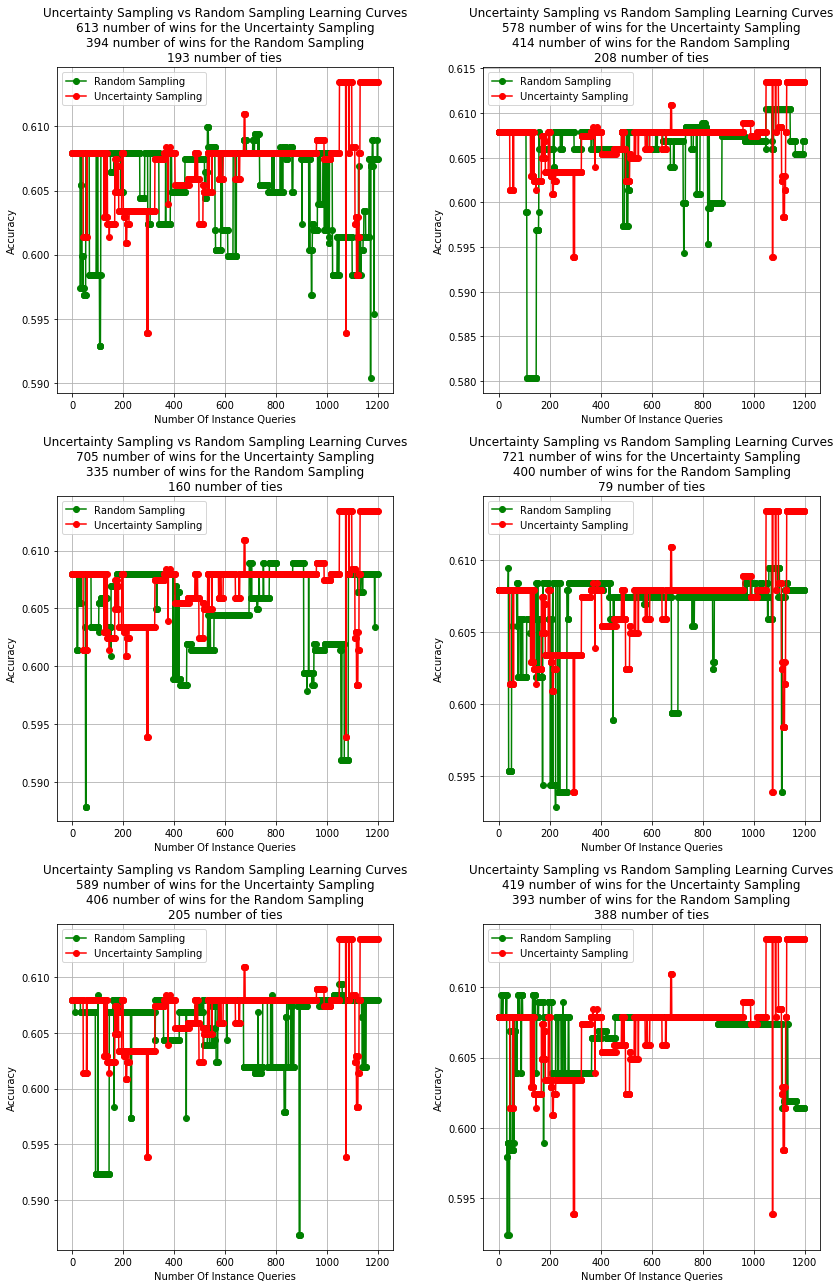

In [0]:
comparison_rows, comparison_columns = 3, 2
n_comparisons = comparison_rows * comparison_columns
n_iterations = 1200
uncertainty_accuracies, random_accuracies, wins, losses, ties = [], [], [], [], []

for i in range(n_comparisons):
    print('Running comparison {} / {}'.format(i + 1, n_comparisons))
    # Run comparison.
    results = run_comparison(n_iterations)
    uncertainty_accuracies.append(results[0])
    random_accuracies.append(results[1])
    wins.append(results[2])
    losses.append(results[3])
    ties.append(results[4])

# Create figures.
fig, ax = plt.subplots(nrows=comparison_rows, ncols=comparison_columns, 
                       figsize=(12, 18))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        # Set title and labels.
        col.set_title('Uncertainty Sampling vs Random Sampling Learning Curves\n'
                      '{} number of wins for the Uncertainty Sampling\n'
                      '{} number of wins for the Random Sampling\n'
                      '{} number of ties'.format(wins[i * comparison_columns + j], 
                                                 losses[i * comparison_columns + j],
                                                 ties[i * comparison_columns + j]))
        col.set_xlabel('Number Of Instance Queries')
        col.set_ylabel('Accuracy')
        
        # Plot uncertainty and random sampling learning curves.
        col.plot(random_accuracies[i * comparison_columns + j], 'o-', color="g",
                 label="Random Sampling")
        col.plot(uncertainty_accuracies[i * comparison_columns + j], 'o-', color="r",
                 label="Uncertainty Sampling")
        
        # Show legends, placed at the best possible location.
        col.legend(loc="best")
        # Create a plot grid.
        col.grid()

# Auto adjust spacing.
plt.tight_layout()

# Show plot.
fig.show()

As we can see, the uncertainty sampling method leads to better results, since it has more wins than the naive random sampling approach.  
Moreover, it seems to bring better results with less samples picked from the pool, though the difference is more obvious after a big number of iterations.

# Conclusion
Uncertainty sampling seems to be an effective method to choose samples for annotation, that are going to boost the performance of our model faster than randomly choosing them. After a number of iterations it is capable of overcoming the naive approache's score.  
Taking the above into consideration, the uncertainty sampling method is suggested to address an Active Learning problem efficiently.